In [151]:
import portfolioTheory as pt
import yftickers as ticks
import numpy as np
import datetime as dt
from scipy.stats import kurtosis
from scipy.stats import norm
from scipy.stats import probplot
import statsmodels.api as sm
import pylab
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

In [2]:
tickers = ticks.ftse100
start=dt.datetime(2000,1,1)
end=dt.datetime(2023,1,1)
threshold=0.9

In [3]:
portfolio = pt.Portfolio(tickers, start, end)
portfolio.getData()
portfolio.cleanData(dateRange=['2002','2023'], threshold=threshold)
portfolio.calculate_stats()

[*********************100%***********************]  101 of 101 completed

3 Failed downloads:
- MGGT.L: No timezone found, symbol may be delisted
- RMG.L: No timezone found, symbol may be delisted
- AUTO: No timezone found, symbol may be delisted
33 columns were removed because there were less observations than the threshold (0.9):
AAL       73.20%
ABDN.L    70.15%
AHT       82.06%
AUTO       0.00%
BME       75.34%
BRBY.L    87.60%
CCH.L     41.20%
CPG       81.42%
EDV       63.31%
ENT.L     76.87%
EXPN.L    69.06%
FLTR      49.55%
FRES.L    62.34%
GLEN.L    49.39%
HIK.L     73.07%
HL.L      66.55%
IAG       82.57%
IHG       83.66%
III       67.39%
INVR.L    61.61%
ITRK.L    88.18%
LAND      42.11%
MGGT.L     0.00%
MNDI.L    66.01%
NWG       64.48%
OCDO.L    52.96%
PHNX.L    55.82%
PRU       89.25%
RMG.L      0.00%
RMV.L     71.53%
SKG.L     67.24%
SMIN      46.18%
UTG       79.96%
dtype: object


# EDA

In [4]:
print('{} years and {} average days'.format(len(portfolio.logReturns.groupby(portfolio.logReturns.index.year)),round(len(portfolio.logReturns)/len(portfolio.logReturns.groupby(portfolio.logReturns.index.year)),3)))

21 years and 236.952 average days


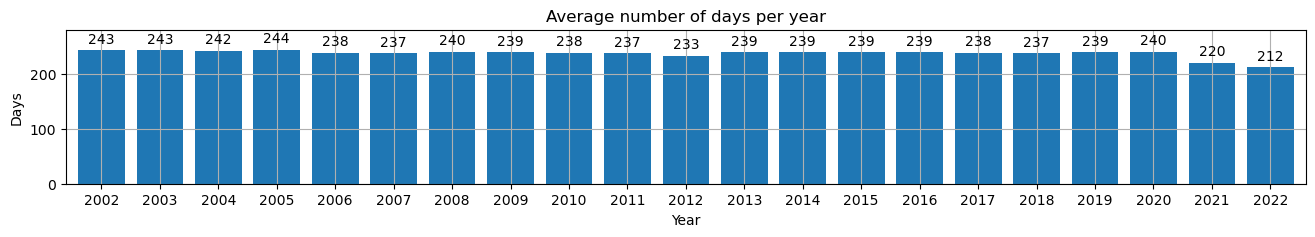

In [5]:
avDays = portfolio.logReturns.groupby(portfolio.logReturns.index.year).count().mean(axis=1)
fig = plt.figure(figsize=(16,2))
plt.bar(avDays.index,avDays.values)
plt.xticks(avDays.index)
plt.ylim(0,280)
plt.margins(x=0.01)
plt.grid()
plt.ylabel('Days')
plt.xlabel('Year')
plt.title('Average number of days per year')
for x,y in zip(avDays.index,avDays.values):

    label = "{}".format(int(y))

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')
plt.show()

In [120]:
fig = px.bar(avDays, x=avDays.index, y=avDays.values, width=800, height=300, text_auto=True, range_y=(0,300), title='Average number of days per year')
fig.update_traces(textfont_size=12, textposition="outside", cliponaxis=False)
fig.update_xaxes(tickmode='linear',tickangle= -90)
fig.update_layout(yaxis_title="Count of days")
fig.show()

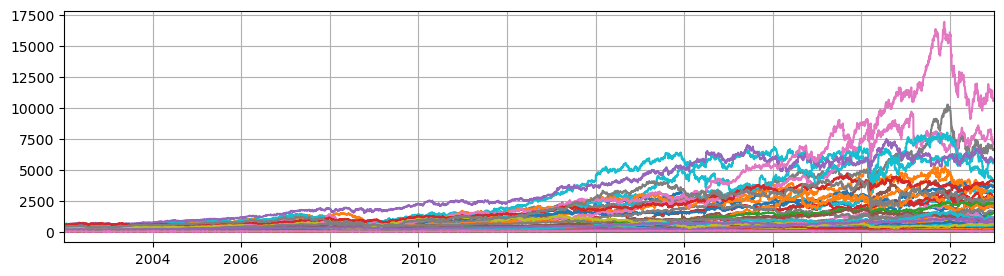

In [414]:
plt.figure(figsize=(12,3))
plt.plot(portfolio.raw_data['Adj Close'])
plt.margins(x=0)
plt.savefig('media/prices')
plt.show()

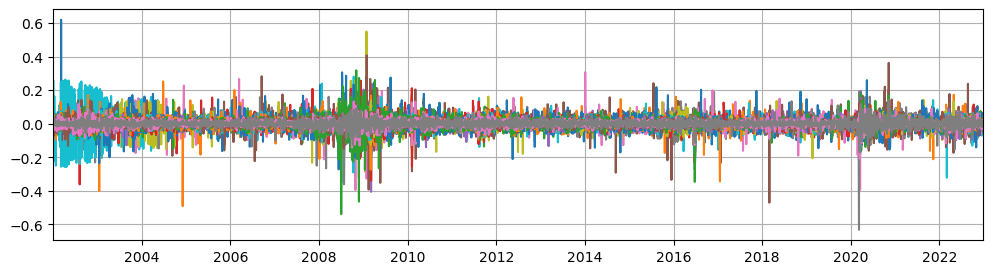

In [415]:
plt.figure(figsize=(12,3))
plt.plot(portfolio.logReturns)
plt.margins(x=0)
plt.savefig('media/Returns')
plt.show()

In [9]:
meanReturns = portfolio.logReturns.mean()
covMatrix = portfolio.covMatrix
portfolio.calculate_PortPerformance(pt.equallyWeighted(meanReturns,covMatrix)[1][1])

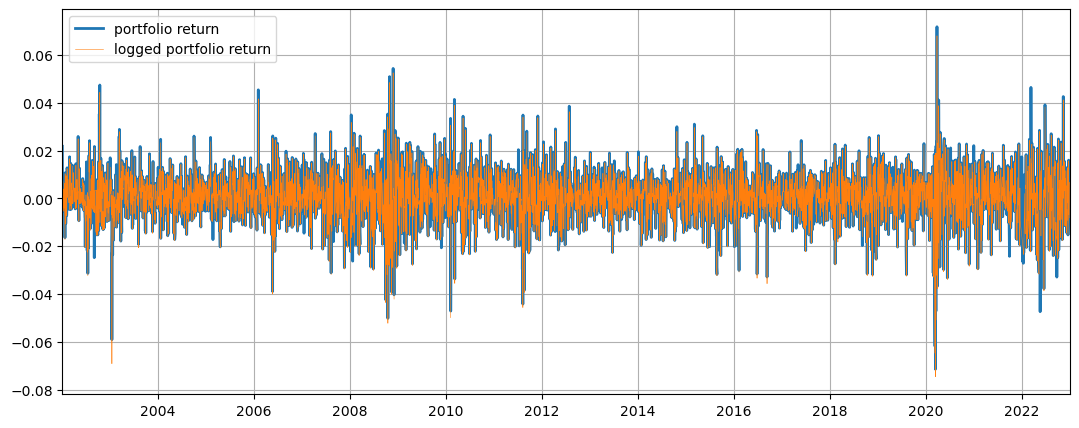

In [416]:
plt.figure(figsize=(13,5))
plt.plot(portfolio.portReturns, lw=2, label='portfolio return')
plt.plot(portfolio.portlogReturns, lw=0.4, label='logged portfolio return')
plt.legend()
plt.margins(x=0)
plt.savefig('media/portReturns')
plt.show()

In [29]:
import pandas as pd

In [30]:
df = pd.concat([portfolio.portReturns,portfolio.portlogReturns], axis=1)

In [68]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio.portReturns.index, y=portfolio.portReturns,
                    mode='lines',
                    name='Returns',
                        marker_size=1,
                        marker_line_width=0.001,
                        line_color='red')
             )
fig.add_trace(go.Scatter(x=portfolio.portlogReturns.index, y=portfolio.portlogReturns,
                    mode='lines',
                    name='Log returns',
                        marker_size=1,
                        marker_line_width=0.01,
                        line_color='blue',
                        opacity=0.7)
             )
fig.update_layout(
    title="Comparing returns with log returns",
    xaxis_title="Date",
    yaxis_title="Returns",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

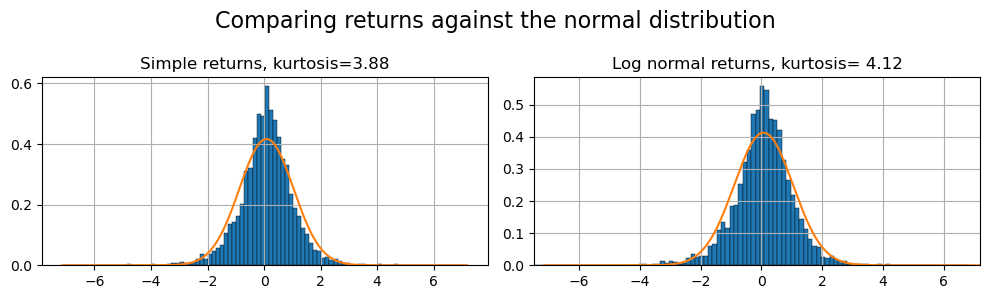

In [417]:
x = np.linspace(portfolio.portReturns.min(),portfolio.portReturns.max(),len(portfolio.portReturns))*100
mu0 = portfolio.portReturns.mean()*100
sigma0 = portfolio.portReturns.std()*100
mu1 = portfolio.portlogReturns.mean()*100
sigma1 = portfolio.portlogReturns.std()*100
fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].hist(portfolio.portReturns*100, bins =100, density=True,edgecolor='black',linewidth=0.3)
ax[0].plot(x, norm.pdf(x, loc=mu0, scale=sigma0))
ax[0].set_title('Simple returns, kurtosis={}'.format(round(kurtosis(portfolio.portReturns, bias=False),2)))
ax[1].hist(portfolio.portlogReturns*100, bins =100, density=True,edgecolor='black',linewidth=0.3)
ax[1].plot(x, norm.pdf(x, loc=mu1, scale=sigma1))
ax[1].set_title('Log normal returns, kurtosis= {}'.format(round(kurtosis(portfolio.portlogReturns, bias=False),2)))
plt.margins(x=0)
fig.suptitle('Comparing returns against the normal distribution', fontsize=16)
plt.tight_layout()
plt.savefig('media/Ndistribution')
plt.show()

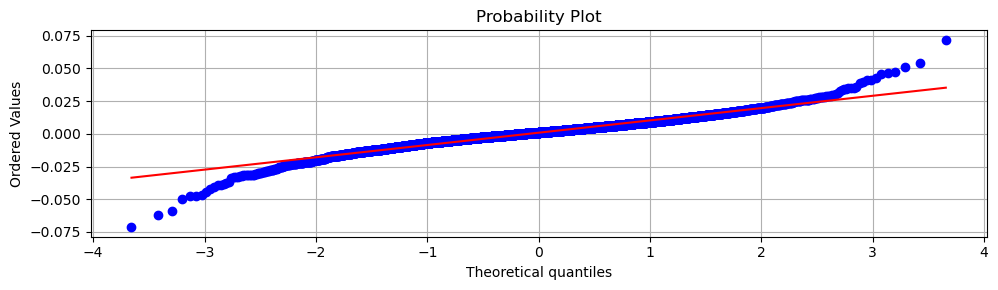

In [418]:
plt.figure(figsize=(10,3))
probplot(portfolio.portReturns, dist="norm", plot=pylab)
plt.tight_layout()
plt.savefig('media/QQ plot')
plt.show()

# Portfolio optimisation

## Initial set up

In [184]:
meanReturns = portfolio.logReturns.mean()
covMatrix = portfolio.covMatrix

In [287]:
maxSR0001 = pt.maxSharpeRatio(meanReturns,covMatrix,contraintSet=(0.0001, 1))
maxSR001 = pt.maxSharpeRatio(meanReturns,covMatrix,contraintSet=(0.001, 1))
maxSR01 = pt.maxSharpeRatio(meanReturns,covMatrix,contraintSet=(0.01, 1))
maxSR = pt.maxSharpeRatio(meanReturns,covMatrix)

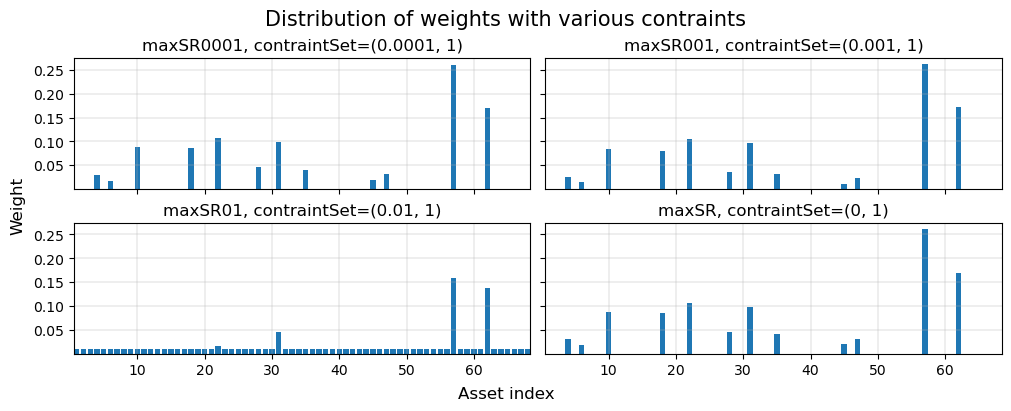

In [419]:
fig, axs = plt.subplots(2,2,figsize=(10,4), layout='constrained', sharey=True, sharex=True)
fig.suptitle('Distribution of weights with various contraints', fontsize=15)
fig.supylabel('Weight')
fig.supxlabel('Asset index')
axs[0][0].bar(np.arange(1,len(maxSR0001[1][1])+1),height=maxSR0001[1][1])
axs[0][0].set_title('maxSR0001, contraintSet=(0.0001, 1)')
axs[0][1].bar(np.arange(1,len(maxSR001[1][1])+1),height=maxSR001[1][1])
axs[0][1].set_title('maxSR001, contraintSet=(0.001, 1)')
axs[1][0].bar(np.arange(1,len(maxSR01[1][1])+1),height=maxSR01[1][1])
axs[1][0].set_title('maxSR01, contraintSet=(0.01, 1)')
axs[1][1].bar(np.arange(1,len(maxSR[1][1])+1),height=maxSR[1][1])
axs[1][1].set_title('maxSR, contraintSet=(0, 1)')
for i in axs.flatten():
    i.yaxis.set_ticks([0.05,0.1,0.15,0.2,0.25])
    i.grid(visible=True,which='both',linewidth=0.3)
    i.margins(x=0)
plt.savefig('media/ConstrainedWeightsDistribution')
plt.show()

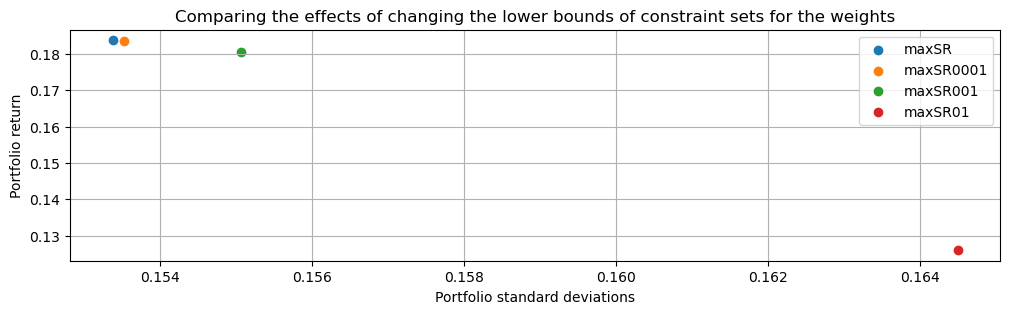

In [420]:
weights_dist_str = ['maxSR', 'maxSR0001', 'maxSR001', 'maxSR01']
weights_dist = [maxSR, maxSR0001, maxSR001, maxSR01]
weights_dist_performance = {}
for i,x in enumerate(weights_dist):
    weights_dist_performance[weights_dist_str[i]]=pt.portfolioPerformance(x[1][1], meanReturns,covMatrix)
df = pd.DataFrame(weights_dist_performance).T
df.rename(columns={0:'returns', 1:'std'}, inplace=True)
plt.figure(figsize=(12,3))
for i in weights_dist_str:
    plt.scatter(y=df.loc[i][0], x=df.loc[i][1], label=i)
plt.title('Comparing the effects of changing the lower bounds of constraint sets for the weights')
plt.ylabel('Portfolio return')
plt.xlabel('Portfolio standard deviations')
plt.legend()
plt.savefig('media/PerformanceOfContraintedWeights')
plt.show()

In [404]:
pt.EF_graph(portfolio.logReturns.mean(), portfolio.covMatrix)